---
title: Spectrum - Coordinate Transformations (Hz to ppm)
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

In Magnetic Resonance Spectroscopy (MRS), spectra are initially reconstructed in the **frequency domain**, measured in Hertz (Hz). This relative frequency axis ($\Delta \nu$) is strictly dependent on the hardware—specifically, the strength of the main magnetic field ($B_0$).

To compare spectra across different scanners (e.g., 1.5T vs 3T vs 7T), we convert this hardware-dependent axis into a hardware-independent axis called **chemical shift**, measured in parts-per-million (ppm).

`xmris` provides dedicated methods to swap between these coordinate systems seamlessly while tracking the physical metadata.

## The Physics & Math

The conversion relies on two critical pieces of metadata that must be stored in your `xarray.DataArray.attrs`:

1. `reference_frequency`: The Larmor frequency of the target nucleus (in MHz).
2. `carrier_ppm`: The absolute chemical shift located exactly at the center of your acquisition band ($0$ Hz). For $^1$H MRS, this is typically the water resonance at $4.7$ ppm.

The mathematical relationships are defined as:

$$ \text{ppm} = \text{carrier\_ppm} + \left( \frac{\text{Hz}}{\text{reference\_frequency}} \right) $$

$$ \text{Hz} = (\text{ppm} - \text{carrier\_ppm}) \times \text{reference\_frequency} $$

```mermaid
flowchart LR

    freq[/"<b>Frequency</b><br>Hz"/]
    shift[/"<b>Chemical Shift</b><br>ppm"/]

    freq -->|".xmr.to_ppm()"| shift
    shift -->|".xmr.to_hz()"| freq

    ref("reference_frequency<br><i>MHz</i>")
    carrier("carrier_ppm<br><i>ppm</i>")

    subgraph attrs ["DataArray.attrs"]
        ref
        carrier
    end

    attrs -.- freq
    attrs -.- shift

    style freq fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
    style shift fill:#e8f5e9,stroke:#388e3c,stroke-width:2px
    style attrs fill:#fff9c4,stroke:#f57f17,stroke-width:1px,stroke-dasharray: 5 5
```

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is registered
import xmris

## 1. Generating a Synthetic Spectrum

Let's generate a mock frequency-domain spectrum (in Hz) acquired on a 3T scanner. We must stamp the required physics metadata into the `.attrs`.

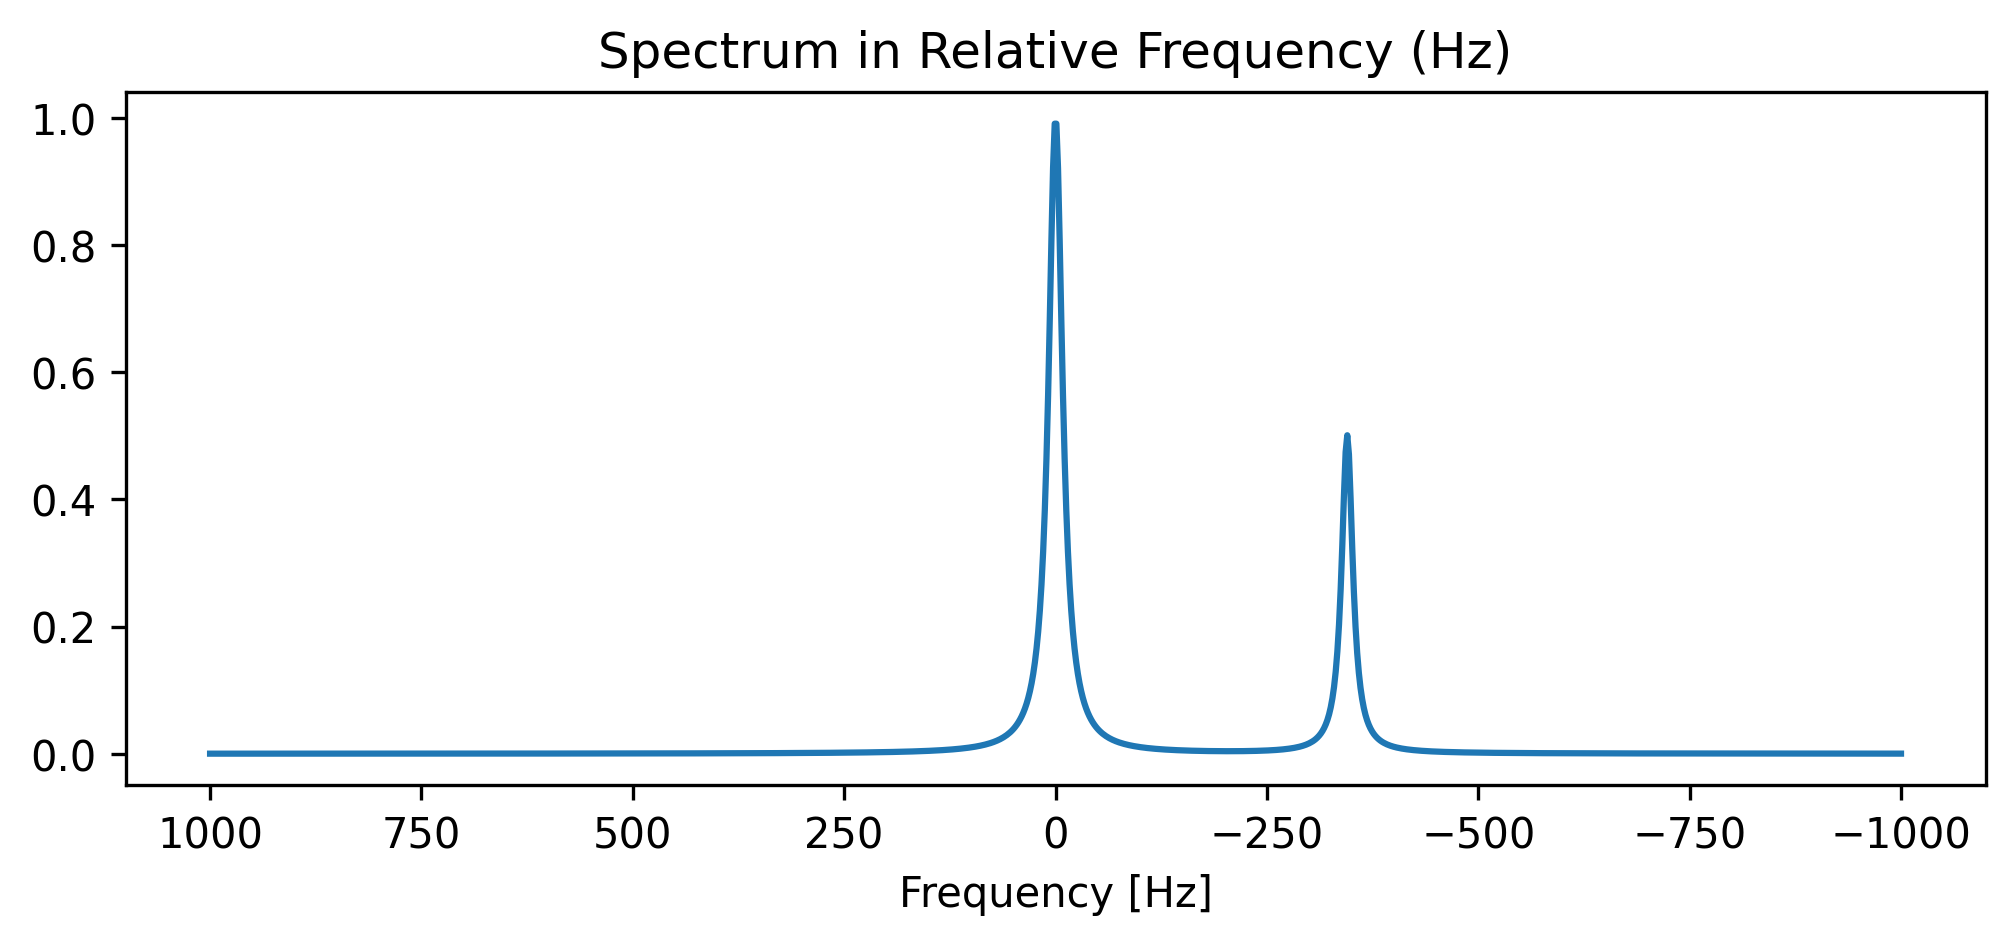

In [3]:
# Simulated acquisition parameters for 3T
mhz = 127.7  # 1H resonance frequency at 3T
carrier = 4.7 # Transmitter centered on water
n_points = 1024
sw_hz = 2000.0 # 2 kHz spectral width

# Generate relative Hz coordinates centered at 0
hz_coords = np.linspace(-sw_hz/2, sw_hz/2, n_points)

# Simulate two peaks: Water (at 0 Hz / 4.7 ppm) and NAA (at roughly -345 Hz / 2.0 ppm)
water_peak = 1.0 / (1 + ((hz_coords - 0) / 10)**2)
naa_peak = 0.5 / (1 + ((hz_coords - (-345)) / 8)**2)
spec_data = water_peak + naa_peak

# Xarray construction with strictly required attrs
da_freq = xr.DataArray(
    spec_data,
    dims=["frequency"],
    coords={"frequency": hz_coords},
    attrs={
        "reference_frequency": mhz,
        "carrier_ppm": carrier,
        "sequence": "PRESS"
    }
)

fig, ax = plt.subplots(figsize=(8, 3))
da_freq.plot(ax=ax)
ax.set_title("Spectrum in Relative Frequency (Hz)")
ax.set_xlabel("Frequency [Hz]")
# Note: In MRS, frequency/ppm axes are traditionally plotted right-to-left
ax.invert_xaxis()
plt.show()

---

## 2. Converting to Chemical Shift (ppm)

Using `.xmr.to_ppm()`, `xmris` calculates the new chemical shift coordinates, creates a properly labeled axis, and automatically swaps the primary dimension of the DataArray from `"frequency"` to `"chemical_shift"`.

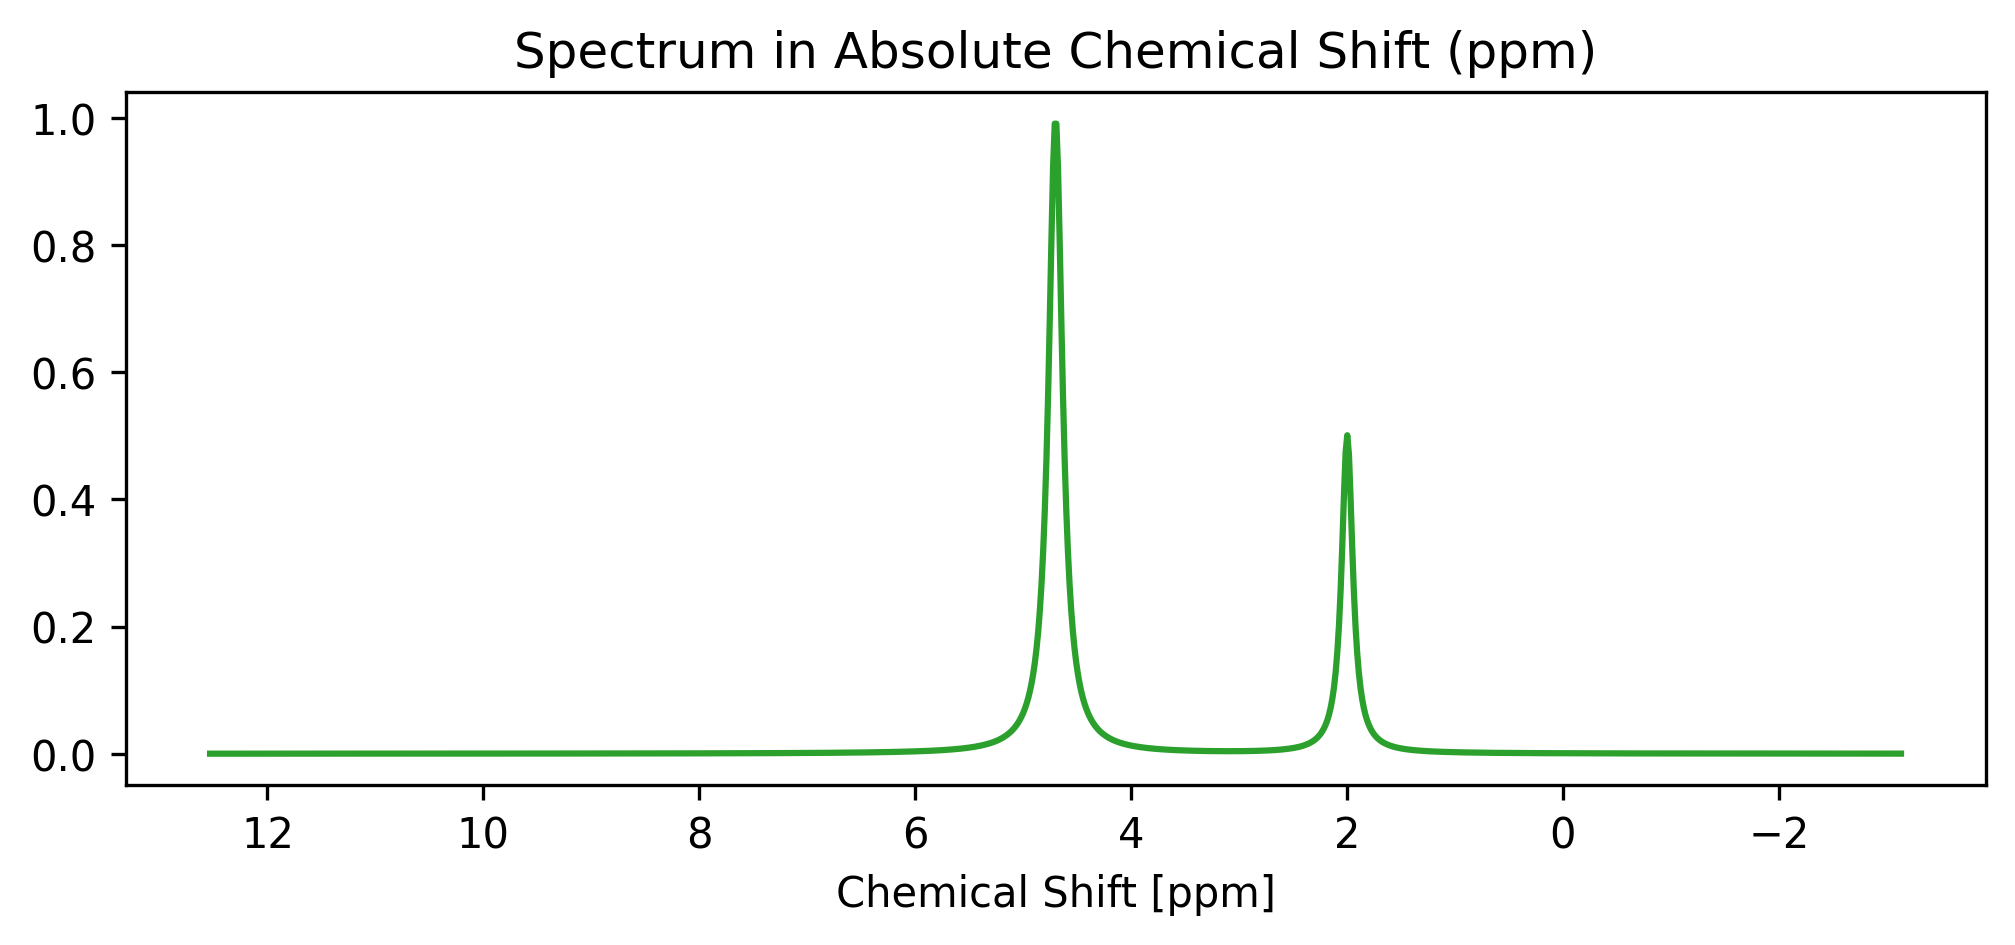

In [4]:
# Convert to ppm using the dimension name as a plain string
da_ppm = da_freq.xmr.to_ppm(dim="frequency")

fig, ax = plt.subplots(figsize=(8, 3))
da_ppm.plot(ax=ax, color="tab:green")
ax.set_title("Spectrum in Absolute Chemical Shift (ppm)")
ax.set_xlabel("Chemical Shift [ppm]")
ax.invert_xaxis()
plt.show()

Notice how the water peak is now correctly centered at $4.7$ ppm, and the NAA peak is positioned around $2.0$ ppm.

:::{dropdown} Under the Hood: The `@requires_attrs` Decorator
If you attempt to call `to_ppm()` on an array that is missing the `"reference_frequency"` or `"carrier_ppm"` attributes, `xmris` will instantly throw a helpful error before any math is executed.

This strict validation guarantees that your physical conversions are always rooted in reality, and prevents silent mathematical drift!
:::

---

## 3. Converting back to Frequency (Hz)

The operation is perfectly invertible using `.xmr.to_hz()`.

Because `xmris` preserves data lineage, the metadata attributes are completely untouched during the first transformation, meaning the DataArray has everything it needs to reconstruct the original Hz axis.

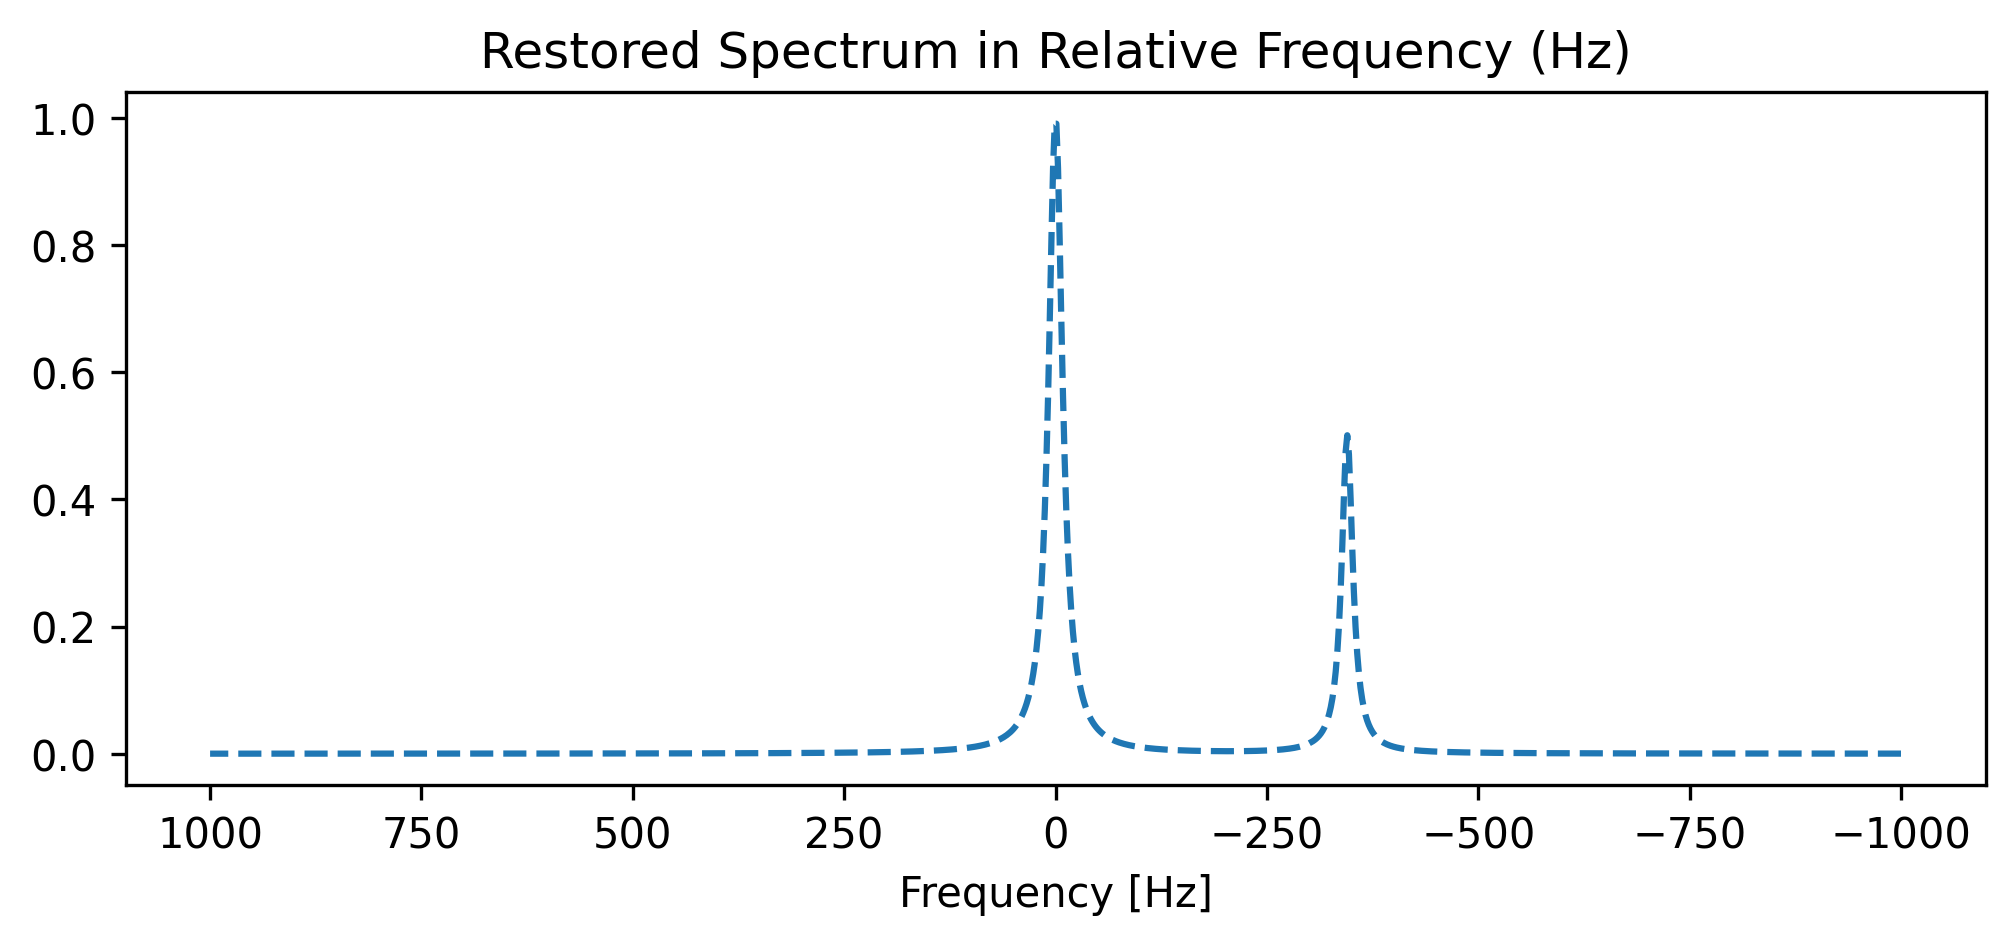

In [5]:
# Convert back to relative frequency (Hz)
da_hz_restored = da_ppm.xmr.to_hz(dim="chemical_shift")

fig, ax = plt.subplots(figsize=(8, 3))
da_hz_restored.plot(ax=ax, color="tab:blue", linestyle="--")
ax.set_title("Restored Spectrum in Relative Frequency (Hz)")
ax.set_xlabel("Frequency [Hz]")
ax.invert_xaxis()
plt.show()

In [6]:
# STRICT TESTS: Coordinate Transformations

# 1. Test to_ppm math and structural integrity
_mhz = da_freq.attrs["reference_frequency"]
_carrier = da_freq.attrs["carrier_ppm"]
_hz_vals = da_freq.coords["frequency"].values

_expected_ppm = _carrier + (_hz_vals / _mhz)

np.testing.assert_allclose(
    da_ppm.coords["chemical_shift"].values, _expected_ppm,
    err_msg="to_ppm math failed."
)
assert da_ppm.dims == ("chemical_shift",), "Dimension swap to chemical_shift failed."
assert "chemical_shift" in da_ppm.coords, "Coordinate assignment failed."
assert da_ppm.attrs == da_freq.attrs, "Attributes were dropped during to_ppm."

# 2. Test to_hz math and structural invertibility
_ppm_vals = da_ppm.coords["chemical_shift"].values
_expected_hz = (_ppm_vals - _carrier) * _mhz

np.testing.assert_allclose(
    da_hz_restored.coords["frequency"].values, _expected_hz,
    err_msg="to_hz math failed."
)
assert da_hz_restored.dims == ("frequency",), "Dimension swap back to frequency failed."
assert "frequency" in da_hz_restored.coords, "Coordinate restoration failed."

# 3. Test absolute invertibility
np.testing.assert_allclose(
    da_hz_restored.values, da_freq.values,
    err_msg="Data values altered during cycle."
)
np.testing.assert_allclose(
    da_hz_restored.coords["frequency"].values, da_freq.coords["frequency"].values,
    err_msg="Original Hz coords not perfectly restored."
)